🎬 Content-Based Movie Recommender (Eq. 3 – Cosine Similarity)

In [1]:
import pandas as pd
import numpy as np
import ast
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from collections import Counter

nltk.download('punkt')
nltk.download('stopwords')


c:\Users\OKTAVIAN\anaconda3\Lib\site-packages\paramiko\pkey.py:82: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
c:\Users\OKTAVIAN\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.Blowfish and will be removed from this module in 45.0.0.
  "class": algorithms.Blowfish,
c:\Users\OKTAVIAN\anaconda3\Lib\site-packages\paramiko\transport.py:243: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "class": algorithms.TripleDES,
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\OKTAVIAN\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopw

True

In [2]:
# 🔄 Load Data dan Filter 7 Judul
movies = pd.read_csv('../Dataset/movies_metadata.csv', low_memory=False, on_bad_lines='skip')
credits = pd.read_csv('../Dataset/credits.csv', on_bad_lines='skip')

movies = movies[['id', 'title', 'genres', 'overview']]
credits = credits[['id', 'cast', 'crew']]
credits['id'] = credits['id'].astype(str)
movies['id'] = movies['id'].astype(str)
df = pd.merge(movies, credits, on='id')

judul_terpilih = [
    '862', '8844', '949', '9091', '863', '65759', '49013'
]
df = df[df['id'].isin(judul_terpilih)].reset_index(drop=True)

In [3]:
df

,id,title,genres,overview,cast,crew
0,862,Toy Story,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...","Led by Woody, Andy's toys live happily in his ...","[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de..."
1,8844,Jumanji,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",When siblings Judy and Peter discover an encha...,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de..."
2,949,Heat,"[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...","Obsessive master thief, Neil McCauley leads a ...","[{'cast_id': 25, 'character': 'Lt. Vincent Han...","[{'credit_id': '52fe4292c3a36847f802916d', 'de..."
3,9091,Sudden Death,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",International action superstar Jean Claude Van...,"[{'cast_id': 1, 'character': 'Darren Francis T...","[{'credit_id': '52fe44dbc3a36847f80ae0f1', 'de..."
4,863,Toy Story 2,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...","Andy heads off to Cowboy Camp, leaving his toy...","[{'cast_id': 18, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8025073', 'de..."
5,49013,Cars 2,"[{'id': 16, 'name': 'Animation'}, {'id': 10751...",Star race car Lightning McQueen and his pal Ma...,"[{'cast_id': 4, 'character': 'Lightning McQuee...","[{'credit_id': '52fe477fc3a36847f8139271', 'de..."
6,65759,Happy Feet Two,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",Mumble the penguin has a problem: his son Erik...,"[{'cast_id': 1, 'character': 'Mumble (voice)',...","[{'credit_id': '52fe4718c3a368484e0b4d57', 'de..."


In [4]:
# Ekstraksi fitur
def parse_genres(x):
    try:
        return [d['name'].lower() for d in ast.literal_eval(x)]
    except:
        return []

def extract_cast(x):
    try:
        return [d['name'].lower() for d in ast.literal_eval(x)[:5]]
    except:
        return []

def extract_director(x):
    try:
        return [d['name'].lower() for d in ast.literal_eval(x) if d['job'].lower() == 'director']
    except:
        return []

df['genres'] = df['genres'].apply(parse_genres)
df['actors'] = df['cast'].apply(extract_cast)
df['director'] = df['crew'].apply(extract_director)

In [5]:
# 🔠 Preprocessing Overview dan Title
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def preprocess(text):
    if pd.isna(text):
        return []
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    tokens = word_tokenize(text)
    tokens = [t for t in tokens if t not in stop_words]
    return [stemmer.stem(t) for t in tokens]

df['processed_overview'] = df['overview'].apply(preprocess)
df['processed_title'] = df['title'].apply(preprocess)
df['combined_features'] = df['processed_title'] + df['genres'] + df['actors'] + df['director']

In [6]:
df['processed_overview']

0    [led, woodi, andi, toy, live, happili, room, a...
1    [sibl, judi, peter, discov, enchant, board, ga...
2    [obsess, master, thief, neil, mccauley, lead, ...
3    [intern, action, superstar, jean, claud, van, ...
4    [andi, head, cowboy, camp, leav, toy, devic, t...
5    [star, race, car, lightn, mcqueen, pal, mater,...
6    [mumbl, penguin, problem, son, erik, reluct, d...
Name: processed_overview, dtype: object

In [7]:
df['processed_overview'].to_csv('../Dataset/processed_overview.csv', index=False)

In [8]:
w2v_model = Word2Vec(df['processed_overview'], vector_size=3, window=5, min_count=1, workers=4)

def vectorize(tokens):
    vectors = [w2v_model.wv[word] for word in tokens if word in w2v_model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(3)

df['overview_vector'] = df['processed_overview'].apply(vectorize)


In [9]:
# Menampilkan mean vector (Word2Vec) untuk setiap film (overview)
mean_vectors = pd.DataFrame(df['overview_vector'].to_list(), index=df['title'])
print('Mean vector (Word2Vec) untuk setiap film:')
print(mean_vectors)

Mean vector (Word2Vec) untuk setiap film:
                       0         1         2
title                                       
Toy Story       0.024388  0.026865 -0.042885
Jumanji        -0.004921  0.027390  0.037805
Heat           -0.047090  0.003584  0.050137
Sudden Death   -0.029745  0.033016 -0.008192
Toy Story 2     0.004014  0.078487 -0.047273
Cars 2          0.035396 -0.080353  0.062854
Happy Feet Two -0.019230 -0.023681  0.016018


In [10]:
# Menampilkan vektor Word2Vec untuk setiap kata unik di overview 7 film
all_words = set([word for doc in df['processed_overview'] for word in doc])
print("Jumlah kata unik di overview:", len(all_words))

Jumlah kata unik di overview: 195


In [11]:
# 🎬 Menampilkan kata unik dari overview berdasarkan urutan title
print("=== KATA UNIK DARI OVERVIEW BERDASARKAN URUTAN TITLE ===")
print()

# Mengurutkan dataframe berdasarkan title
df_sorted = df.sort_values('title').reset_index(drop=True)

# Menampilkan kata unik dari overview untuk setiap film berdasarkan urutan title
for i in range(len(df_sorted)):
    title = df_sorted.loc[i, 'title']
    overview_words = df_sorted.loc[i, 'processed_overview']
    
    print(f"Film #{i+1}: {title}")
    print(f"Kata unik dari overview: {overview_words}")
    print(f"Jumlah kata: {len(overview_words)}")
    print("-" * 70)
    print()

=== KATA UNIK DARI OVERVIEW BERDASARKAN URUTAN TITLE ===

Film #1: Cars 2
Kata unik dari overview: ['star', 'race', 'car', 'lightn', 'mcqueen', 'pal', 'mater', 'head', 'oversea', 'compet', 'world', 'grand', 'prix', 'race', 'road', 'championship', 'becom', 'rocki', 'mater', 'get', 'caught', 'intrigu', 'adventur', 'intern', 'espionag']
Jumlah kata: 25
----------------------------------------------------------------------

Film #2: Happy Feet Two
Kata unik dari overview: ['mumbl', 'penguin', 'problem', 'son', 'erik', 'reluct', 'danc', 'encount', 'mighti', 'sven', 'penguin', 'fli', 'thing', 'get', 'wors', 'mumbl', 'world', 'shaken', 'power', 'forc', 'caus', 'bring', 'togeth', 'penguin', 'nation', 'alli', 'set', 'thing', 'right']
Jumlah kata: 29
----------------------------------------------------------------------

Film #3: Heat
Kata unik dari overview: ['obsess', 'master', 'thief', 'neil', 'mccauley', 'lead', 'topnotch', 'crew', 'variou', 'insan', 'heist', 'throughout', 'lo', 'angel', 'me

In [12]:
# 📊 Analisis statistik kata unik overview (diurutkan berdasarkan title)
print("=== ANALISIS STATISTIK KATA UNIK OVERVIEW (URUT BERDASARKAN TITLE) ===")
print()

# Mengurutkan dataframe berdasarkan title
df_sorted = df.sort_values('title').reset_index(drop=True)

# Mengumpulkan statistik
total_kata_per_film = []
semua_kata_unik = set()

print("Ringkasan per film (diurutkan berdasarkan title):")
print()
for i in range(len(df_sorted)):
    title = df_sorted.loc[i, 'title']
    overview_words = df_sorted.loc[i, 'processed_overview']
    jumlah_kata = len(overview_words)
    
    total_kata_per_film.append(jumlah_kata)
    semua_kata_unik.update(overview_words)
    
    print(f"{i+1:2d}. {title:<35} - {jumlah_kata:3d} kata")

print()
print("=== STATISTIK KESELURUHAN ===")
print(f"Total film: {len(df_sorted)}")
print(f"Rata-rata kata per overview: {np.mean(total_kata_per_film):.2f}")
print(f"Overview dengan kata terbanyak: {max(total_kata_per_film)} kata")
print(f"Overview dengan kata tersedikit: {min(total_kata_per_film)} kata")
print(f"Total kata unik dari semua overview: {len(semua_kata_unik)}")

# Film dengan overview terpanjang dan terpendek
idx_max = np.argmax(total_kata_per_film)
idx_min = np.argmin(total_kata_per_film)
print()
print(f"Film dengan overview terpanjang: '{df_sorted.loc[idx_max, 'title']}' ({total_kata_per_film[idx_max]} kata)")
print(f"Film dengan overview terpendek: '{df_sorted.loc[idx_min, 'title']}' ({total_kata_per_film[idx_min]} kata)")

=== ANALISIS STATISTIK KATA UNIK OVERVIEW (URUT BERDASARKAN TITLE) ===

Ringkasan per film (diurutkan berdasarkan title):

 1. Cars 2                              -  25 kata
 2. Happy Feet Two                      -  29 kata
 3. Heat                                -  35 kata
 4. Jumanji                             -  39 kata
 5. Sudden Death                        -  47 kata
 6. Toy Story                           -  33 kata
 7. Toy Story 2                         -  38 kata

=== STATISTIK KESELURUHAN ===
Total film: 7
Rata-rata kata per overview: 35.14
Overview dengan kata terbanyak: 47 kata
Overview dengan kata tersedikit: 25 kata
Total kata unik dari semua overview: 195

Film dengan overview terpanjang: 'Sudden Death' (47 kata)
Film dengan overview terpendek: 'Cars 2' (25 kata)


In [13]:
# 📋 Daftar semua kata unik dari overview (terurut alfabetis)
print("=== DAFTAR SEMUA KATA UNIK DARI OVERVIEW ===")
print()

# Mengumpulkan semua kata unik dari overview
semua_kata_overview = set()
for overview_words in df['processed_overview']:
    semua_kata_overview.update(overview_words)

# Mengurutkan kata secara alfabetis
kata_terurut = sorted(list(semua_kata_overview))

print(f"Total kata unik dalam overview: {len(kata_terurut)}")
print()
print("Daftar kata unik (urut alfabetis):")
print()

# Menampilkan kata dalam format kolom
for i, kata in enumerate(kata_terurut, 1):
    print(f"{i:3d}. {kata:<20}", end="")
    # Baris baru setiap 3 kata untuk tampilan yang rapi
    if i % 3 == 0:
        print()
        
# Tambahkan baris baru jika tidak habis dibagi 3
if len(kata_terurut) % 3 != 0:
    print()

print()
print("=== SAMPEL KATA BERDASARKAN PANJANG ===")
print()

# Kelompokkan kata berdasarkan panjang
kata_pendek = [kata for kata in kata_terurut if len(kata) <= 3]
kata_sedang = [kata for kata in kata_terurut if 4 <= len(kata) <= 7]
kata_panjang = [kata for kata in kata_terurut if len(kata) >= 8]

print(f"Kata pendek (≤3 karakter): {len(kata_pendek)} kata")
print(f"Contoh: {kata_pendek[:10]}")
print()
print(f"Kata sedang (4-7 karakter): {len(kata_sedang)} kata")
print(f"Contoh: {kata_sedang[:10]}")
print()
print(f"Kata panjang (≥8 karakter): {len(kata_panjang)} kata")
print(f"Contoh: {kata_panjang[:10]}")

=== DAFTAR SEMUA KATA UNIK DARI OVERVIEW ===

Total kata unik dalam overview: 195

Daftar kata unik (urut alfabetis):

  1. 26                    2. abil                  3. abort               
  4. action                5. adult                 6. adventur            
  7. afraid                8. al                    9. alan                
 10. alli                 11. andi                 12. angel               
 13. asid                 14. awar                 15. backdrop            
 16. barn                 17. becom                18. belong              
 19. billion              20. birthday             21. board               
 22. booth                23. bring                24. buzz                
 25. buzzer               26. camp                 27. captor              
 28. car                  29. catandmous           30. caught              
 31. caus                 32. championship         33. circumst            
 34. claud                35. collector      

In [14]:
# Output DataFrame vektor kata Word2Vec untuk semua kata unik di overview 7 film
word_vectors = {word: w2v_model.wv[word] for word in all_words if word in w2v_model.wv}
df_vectors = pd.DataFrame(word_vectors).T  # index=kata, kolom=dimensi vektor
df_vectors

,0,1,2
danc,0.024915,0.186185,-0.286545
gamevan,-0.149405,0.305053,-0.187014
afraid,0.109515,0.049794,-0.029962
find,-0.161743,0.282152,0.175941
angel,-0.026469,-0.222536,-0.236032
...,...,...,...
explos,-0.122619,0.104633,-0.318605
encount,0.025107,-0.280537,0.261029
grand,0.022426,-0.126015,-0.237117
though,-0.073384,0.318450,0.317451


In [15]:
def jaccard_similarity(list1, list2):
    set1, set2 = set(list1), set(list2)
    return len(set1 & set2) / len(set1 | set2) if set1 or set2 else 0.0


In [16]:
def recommend(title_input, top_n=10,
              alpha=1, beta=1, gamma=1, theta=1, delta=1):
    """
    Sistem rekomendasi menggunakan cosine similarity (Eq. 3) untuk overview.
    """
    title_input = title_input.lower()
    if title_input not in df['title'].str.lower().values:
        print(f"Film '{title_input}' tidak ditemukan.")
        return []

    idx = df[df['title'].str.lower() == title_input].index[0]

    # Fitur target
    genre_i     = df.loc[idx, 'genres']
    actors_i    = df.loc[idx, 'actors']
    director_i  = df.loc[idx, 'director']
    title_i     = df.loc[idx, 'processed_title']
    overview_i  = df.loc[idx, 'overview_vector'].reshape(1, -1)

    results = []

    print(f"\n📊 Menghitung kemiripan dengan '{df.loc[idx, 'title']}' (menggunakan Eq. 3):\n")

    for j in range(len(df)):
        if j == idx:
            continue

        genre_sim    = jaccard_similarity(genre_i, df.loc[j, 'genres'])
        actor_sim    = jaccard_similarity(actors_i, df.loc[j, 'actors'])
        director_sim = jaccard_similarity(director_i, df.loc[j, 'director'])
        title_sim    = jaccard_similarity(title_i, df.loc[j, 'processed_title'])

        overview_j = df.loc[j, 'overview_vector'].reshape(1, -1)
        overview_sim = cosine_similarity(overview_i, overview_j)[0][0]

        final_score = (
            (alpha * genre_sim +
            beta * actor_sim +
            gamma * director_sim +
            theta * title_sim +
            delta * overview_sim) / 5
        )

        print(f"- {df.loc[j, 'title']}:\n  Genre={genre_sim:.3f}, Actor={actor_sim:.3f}, Director={director_sim:.3f}, Title={title_sim:.3f}, Overview={overview_sim:.3f}")
        print(f"  → Final Score: {final_score:.3f}\n")

        results.append((j, final_score))

    top = sorted(results, key=lambda x: x[1], reverse=True)[:top_n]
    return [(df.loc[i, 'title'], round(score, 3)) for i, score in top]


In [17]:
hasil = recommend("Toy Story", top_n=10)

print("\n🎬 Top 10 Rekomendasi (menggunakan Eq. 3 – cosine):")
for title, sim in hasil:
    print(f"- {title} (Similarity: {sim})")



📊 Menghitung kemiripan dengan 'Toy Story' (menggunakan Eq. 3):

- Jumanji:
  Genre=0.200, Actor=0.000, Director=0.000, Title=0.000, Overview=-0.381
  → Final Score: -0.036

- Heat:
  Genre=0.000, Actor=0.000, Director=0.000, Title=0.000, Overview=-0.828
  → Final Score: -0.166

- Sudden Death:
  Genre=0.000, Actor=0.000, Director=0.000, Title=0.000, Overview=0.202
  → Final Score: 0.040

- Toy Story 2:
  Genre=1.000, Actor=0.429, Director=1.000, Title=0.667, Overview=0.822
  → Final Score: 0.783

- Cars 2:
  Genre=0.750, Actor=0.000, Director=0.500, Title=0.000, Overview=-0.658
  → Final Score: 0.118

- Happy Feet Two:
  Genre=1.000, Actor=0.000, Director=0.000, Title=0.000, Overview=-0.926
  → Final Score: 0.015


🎬 Top 10 Rekomendasi (menggunakan Eq. 3 – cosine):
- Toy Story 2 (Similarity: 0.783)
- Cars 2 (Similarity: 0.118)
- Sudden Death (Similarity: 0.04)
- Happy Feet Two (Similarity: 0.015)
- Jumanji (Similarity: -0.036)
- Heat (Similarity: -0.166)


In [18]:
# 📊 Evaluasi Model Menggunakan Precision
import random
from sklearn.metrics import precision_score

def evaluate_precision(test_samples=50, top_k=5):
    """
    Evaluasi model menggunakan precision.
    Precision = (Relevant items recommended) / (Total items recommended)
    """
    print("=== EVALUASI MODEL MENGGUNAKAN PRECISION ===")
    print()
    
    # Sampling film untuk testing
    sample_indices = random.sample(range(len(df)), min(test_samples, len(df)))
    
    precision_scores = []
    total_relevant = 0
    total_recommended = 0
    
    print(f"Menguji {len(sample_indices)} film dengan top-{top_k} rekomendasi...")
    print()
    
    for i, idx in enumerate(sample_indices):
        test_title = df.loc[idx, 'title']
        test_genres = set(df.loc[idx, 'genres'])
        
        # Dapatkan rekomendasi
        recommendations = recommend(test_title, top_n=top_k, 
                                   alpha=1, beta=1, gamma=1, theta=1, delta=1)
        
        if not recommendations:
            continue
            
        # Hitung precision berdasarkan genre similarity
        relevant_count = 0
        for rec_title, score in recommendations:
            # Cari film rekomendasi
            rec_idx = df[df['title'] == rec_title].index
            if len(rec_idx) > 0:
                rec_genres = set(df.loc[rec_idx[0], 'genres'])
                # Anggap relevan jika memiliki setidaknya 1 genre yang sama
                if len(test_genres.intersection(rec_genres)) > 0:
                    relevant_count += 1
        
        precision = relevant_count / len(recommendations) if recommendations else 0
        precision_scores.append(precision)
        
        total_relevant += relevant_count
        total_recommended += len(recommendations)
        
        if i < 5:  # Tampilkan 5 contoh pertama
            print(f"Film #{i+1}: {test_title}")
            print(f"  Genre: {list(test_genres)}")
            print(f"  Rekomendasi relevan: {relevant_count}/{len(recommendations)}")
            print(f"  Precision: {precision:.3f}")
            print()
    
    # Hitung metrik keseluruhan
    avg_precision = sum(precision_scores) / len(precision_scores) if precision_scores else 0
    macro_precision = total_relevant / total_recommended if total_recommended > 0 else 0
    
    print("=== HASIL EVALUASI ===")
    print(f"Jumlah film yang diuji: {len(precision_scores)}")
    print(f"Average Precision (Micro): {avg_precision:.4f}")
    print(f"Macro Precision: {macro_precision:.4f}")
    print(f"Total item relevan: {total_relevant}")
    print(f"Total item direkomendasi: {total_recommended}")
    
    return precision_scores, avg_precision, macro_precision

In [19]:
# 🏆 Menjalankan Evaluasi Precision
# Set random seed untuk reproducibility
random.seed(42)

# Jalankan evaluasi dengan 20 film sample dan top-5 rekomendasi
precision_scores, avg_precision, macro_precision = evaluate_precision(test_samples=20, top_k=5)

print("\n=== DISTRIBUSI PRECISION SCORES ===")
print(f"Precision scores: {[f'{p:.3f}' for p in precision_scores[:10]]}...")  # Tampilkan 10 pertama
print(f"Precision tertinggi: {max(precision_scores):.3f}")
print(f"Precision terendah: {min(precision_scores):.3f}")
print(f"Standar deviasi: {np.std(precision_scores):.3f}")

=== EVALUASI MODEL MENGGUNAKAN PRECISION ===

Menguji 7 film dengan top-5 rekomendasi...


📊 Menghitung kemiripan dengan 'Cars 2' (menggunakan Eq. 3):

- Toy Story:
  Genre=0.750, Actor=0.000, Director=0.500, Title=0.000, Overview=-0.658
  → Final Score: 0.118

- Jumanji:
  Genre=0.400, Actor=0.000, Director=0.000, Title=0.000, Overview=0.000
  → Final Score: 0.080

- Heat:
  Genre=0.000, Actor=0.000, Director=0.000, Title=0.000, Overview=0.161
  → Final Score: 0.032

- Sudden Death:
  Genre=0.167, Actor=0.000, Director=0.000, Title=0.000, Overview=-0.865
  → Final Score: -0.140

- Toy Story 2:
  Genre=0.750, Actor=0.000, Director=0.500, Title=0.250, Overview=-0.923
  → Final Score: 0.115

- Happy Feet Two:
  Genre=0.750, Actor=0.000, Director=0.000, Title=0.000, Overview=0.599
  → Final Score: 0.270

Film #1: Cars 2
  Genre: ['family', 'comedy', 'animation', 'adventure']
  Rekomendasi relevan: 4/5
  Precision: 0.800


📊 Menghitung kemiripan dengan 'Toy Story' (menggunakan Eq. 3):

- J

- Sudden Death:
  Genre=0.000, Actor=0.000, Director=0.000, Title=0.000, Overview=0.202
  → Final Score: 0.040

- Toy Story 2:
  Genre=1.000, Actor=0.429, Director=1.000, Title=0.667, Overview=0.822
  → Final Score: 0.783

- Cars 2:
  Genre=0.750, Actor=0.000, Director=0.500, Title=0.000, Overview=-0.658
  → Final Score: 0.118

- Happy Feet Two:
  Genre=1.000, Actor=0.000, Director=0.000, Title=0.000, Overview=-0.926
  → Final Score: 0.015

Film #2: Toy Story
  Genre: ['family', 'comedy', 'animation']
  Rekomendasi relevan: 4/5
  Precision: 0.800


📊 Menghitung kemiripan dengan 'Happy Feet Two' (menggunakan Eq. 3):

- Toy Story:
  Genre=1.000, Actor=0.000, Director=0.000, Title=0.000, Overview=-0.926
  → Final Score: 0.015

- Jumanji:
  Genre=0.200, Actor=0.111, Director=0.000, Title=0.000, Overview=0.032
  → Final Score: 0.069

- Heat:
  Genre=0.000, Actor=0.000, Director=0.000, Title=0.000, Overview=0.684
  → Final Score: 0.137

- Sudden Death:
  Genre=0.000, Actor=0.000, Director=0.

In [20]:
# 📈 Analisis Detail Evaluasi Precision

def evaluate_precision_by_genre(top_k=5):
    """
    Evaluasi precision berdasarkan genre film
    """
    print("=== EVALUASI PRECISION BERDASARKAN GENRE ===")
    print()
    
    # Kumpulkan semua genre unik
    all_genres = set()
    for genres in df['genres']:
        all_genres.update(genres)
    
    genre_precision = {}
    
    for genre in list(all_genres)[:5]:  # Test 5 genre utama
        # Cari film dengan genre ini
        genre_films = df[df['genres'].apply(lambda x: genre in x)]
        
        if len(genre_films) < 2:
            continue
            
        # Sample beberapa film dari genre ini
        sample_size = min(3, len(genre_films))
        sample_films = genre_films.sample(n=sample_size)
        
        precision_scores = []
        
        for idx, film in sample_films.iterrows():
            test_title = film['title']
            test_genres = set(film['genres'])
            
            recommendations = recommend(test_title, top_n=top_k,
                                       alpha=1, beta=1, gamma=1, theta=1, delta=1)
            
            if not recommendations:
                continue
                
            relevant_count = 0
            for rec_title, score in recommendations:
                rec_idx = df[df['title'] == rec_title].index
                if len(rec_idx) > 0:
                    rec_genres = set(df.loc[rec_idx[0], 'genres'])
                    if len(test_genres.intersection(rec_genres)) > 0:
                        relevant_count += 1
            
            precision = relevant_count / len(recommendations)
            precision_scores.append(precision)
        
        if precision_scores:
            avg_precision = sum(precision_scores) / len(precision_scores)
            genre_precision[genre] = avg_precision
            print(f"Genre '{genre}': Precision = {avg_precision:.3f} (dari {len(precision_scores)} film)")
    
    return genre_precision

# Jalankan evaluasi per genre
genre_results = evaluate_precision_by_genre(top_k=5)

=== EVALUASI PRECISION BERDASARKAN GENRE ===


📊 Menghitung kemiripan dengan 'Sudden Death' (menggunakan Eq. 3):

- Toy Story:
  Genre=0.000, Actor=0.000, Director=0.000, Title=0.000, Overview=0.202
  → Final Score: 0.040

- Jumanji:
  Genre=0.200, Actor=0.000, Director=0.000, Title=0.000, Overview=0.349
  → Final Score: 0.110

- Heat:
  Genre=0.400, Actor=0.000, Director=0.000, Title=0.000, Overview=0.356
  → Final Score: 0.151

- Toy Story 2:
  Genre=0.000, Actor=0.000, Director=0.000, Title=0.000, Overview=0.690
  → Final Score: 0.138

- Cars 2:
  Genre=0.167, Actor=0.000, Director=0.000, Title=0.000, Overview=-0.865
  → Final Score: -0.140

- Happy Feet Two:
  Genre=0.000, Actor=0.000, Director=0.000, Title=0.000, Overview=-0.219
  → Final Score: -0.044


📊 Menghitung kemiripan dengan 'Heat' (menggunakan Eq. 3):

- Toy Story:
  Genre=0.000, Actor=0.000, Director=0.000, Title=0.000, Overview=-0.828
  → Final Score: -0.166

- Jumanji:
  Genre=0.000, Actor=0.000, Director=0.000, Title

In [21]:
# 📊 Comprehensive Evaluation Metrics (Enhanced)
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

def create_ground_truth_by_genre_7movies(df):
    """
    Create ground truth based on genre similarity for 7 movies dataset
    Movies with at least 1 common genre are considered relevant
    """
    ground_truth = {}
    
    for i, row in df.iterrows():
        title = row['title']
        target_genres = set(row['genres'])
        relevant_movies = []
        
        for j, other_row in df.iterrows():
            if i != j:
                other_genres = set(other_row['genres'])
                # Consider movies with at least 1 common genre as relevant
                if len(target_genres & other_genres) > 0:
                    relevant_movies.append(other_row['title'])
        
        ground_truth[title] = relevant_movies
    
    return ground_truth

def evaluate_comprehensive_metrics_7movies(df, ground_truth, top_n=5, **params):
    """
    Evaluate precision, accuracy, recall, and F1 score for 7 movies dataset
    """
    total_precision = 0
    total_recall = 0
    total_f1 = 0
    total_accuracy = 0
    
    y_true_all = []
    y_pred_all = []
    
    evaluation_details = []
    
    # Test all 7 movies since dataset is small
    for title in df['title']:
        try:
            # Get recommendations
            recommendations = recommend(title.lower(), top_n=top_n, **params)
            recommended_titles = [rec[0] for rec in recommendations]
            
            # Get ground truth
            true_relevant = set(ground_truth.get(title, []))
            
            # Calculate metrics for this query
            true_positives = len(set(recommended_titles) & true_relevant)
            false_positives = len(set(recommended_titles) - true_relevant)
            false_negatives = len(true_relevant - set(recommended_titles))
            
            # All other movies in dataset (not recommended and not relevant)
            all_movies = set(df['title'].tolist()) - {title}
            true_negatives = len(all_movies - true_relevant - set(recommended_titles))
            
            # Calculate individual metrics
            precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
            recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
            f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
            accuracy = (true_positives + true_negatives) / (true_positives + true_negatives + false_positives + false_negatives)
            
            total_precision += precision
            total_recall += recall
            total_f1 += f1
            total_accuracy += accuracy
            
            # Store for binary classification metrics
            for movie in all_movies:
                y_true_all.append(1 if movie in true_relevant else 0)
                y_pred_all.append(1 if movie in recommended_titles else 0)
            
            evaluation_details.append({
                'title': title,
                'precision': precision,
                'recall': recall,
                'f1': f1,
                'accuracy': accuracy,
                'true_positives': true_positives,
                'false_positives': false_positives,
                'false_negatives': false_negatives,
                'true_negatives': true_negatives,
                'recommended': recommended_titles,
                'relevant': list(true_relevant)
            })
            
        except Exception as e:
            print(f"Error evaluating {title}: {e}")
            continue
    
    num_queries = len(evaluation_details)
    
    if num_queries == 0:
        return None
    
    # Calculate average metrics
    avg_precision = total_precision / num_queries
    avg_recall = total_recall / num_queries
    avg_f1 = total_f1 / num_queries
    avg_accuracy = total_accuracy / num_queries
    
    # Overall binary classification metrics
    overall_precision = precision_score(y_true_all, y_pred_all, zero_division=0)
    overall_recall = recall_score(y_true_all, y_pred_all, zero_division=0)
    overall_f1 = f1_score(y_true_all, y_pred_all, zero_division=0)
    overall_accuracy = accuracy_score(y_true_all, y_pred_all)
    
    return {
        'avg_precision': avg_precision,
        'avg_recall': avg_recall,
        'avg_f1': avg_f1,
        'avg_accuracy': avg_accuracy,
        'overall_precision': overall_precision,
        'overall_recall': overall_recall,
        'overall_f1': overall_f1,
        'overall_accuracy': overall_accuracy,
        'num_queries': num_queries,
        'details': evaluation_details
    }

def evaluate_by_genre_7movies(df, ground_truth, top_n=5, **params):
    """
    Evaluate metrics by genre for 7 movies dataset
    """
    genre_metrics = {}
    
    # Get all unique genres
    all_genres = set()
    for genres in df['genres']:
        all_genres.update(genres)
    
    for genre in all_genres:
        genre_movies = df[df['genres'].apply(lambda x: genre in x)]
        if len(genre_movies) < 1:
            continue
            
        total_precision = 0
        total_recall = 0
        total_f1 = 0
        total_accuracy = 0
        count = 0
        
        # Test all movies with this genre
        for title in genre_movies['title']:
            try:
                recommendations = recommend(title.lower(), top_n=top_n, **params)
                recommended_titles = [rec[0] for rec in recommendations]
                
                true_relevant = set(ground_truth.get(title, []))
                
                true_positives = len(set(recommended_titles) & true_relevant)
                false_positives = len(set(recommended_titles) - true_relevant)
                false_negatives = len(true_relevant - set(recommended_titles))
                
                all_movies = set(df['title'].tolist()) - {title}
                true_negatives = len(all_movies - true_relevant - set(recommended_titles))
                
                precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
                recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
                f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
                accuracy = (true_positives + true_negatives) / (true_positives + true_negatives + false_positives + false_negatives)
                
                total_precision += precision
                total_recall += recall
                total_f1 += f1
                total_accuracy += accuracy
                count += 1
                
            except Exception as e:
                continue
        
        if count > 0:
            genre_metrics[genre] = {
                'precision': total_precision / count,
                'recall': total_recall / count,
                'f1': total_f1 / count,
                'accuracy': total_accuracy / count,
                'num_movies': count
            }
    
    return genre_metrics

In [22]:
# 🔍 Parameter Optimization and Comparison for 7 Movies
def optimize_parameters_7movies(df, ground_truth, top_n=5):
    """
    Test different parameter combinations and find the best one for 7 movies dataset
    """
    parameter_combinations = [
        {'alpha': 1, 'beta': 1, 'gamma': 1, 'theta': 1, 'delta': 1},  # Equal weights
        {'alpha': 2, 'beta': 1, 'gamma': 1, 'theta': 1, 'delta': 1},  # Genre emphasis
        {'alpha': 1, 'beta': 2, 'gamma': 1, 'theta': 1, 'delta': 1},  # Actor emphasis
        {'alpha': 1, 'beta': 1, 'gamma': 2, 'theta': 1, 'delta': 1},  # Director emphasis
        {'alpha': 1, 'beta': 1, 'gamma': 1, 'theta': 2, 'delta': 1},  # Title emphasis
        {'alpha': 1, 'beta': 1, 'gamma': 1, 'theta': 1, 'delta': 2},  # Overview emphasis
        {'alpha': 0.5, 'beta': 0.5, 'gamma': 0.5, 'theta': 0.5, 'delta': 3},  # Heavy overview
        {'alpha': 3, 'beta': 0.5, 'gamma': 0.5, 'theta': 0.5, 'delta': 0.5},  # Heavy genre
        {'alpha': 1, 'beta': 3, 'gamma': 1, 'theta': 1, 'delta': 1},  # Heavy actor focus
        {'alpha': 1, 'beta': 1, 'gamma': 3, 'theta': 1, 'delta': 1},  # Heavy director focus
    ]
    
    results = []
    
    print("🔍 Testing parameter combinations for 7 movies dataset...")
    
    for i, params in enumerate(parameter_combinations):
        print(f"\nTesting combination {i+1}/{len(parameter_combinations)}: {params}")
        
        metrics = evaluate_comprehensive_metrics_7movies(df, ground_truth, top_n=top_n, **params)
        
        if metrics:
            results.append({
                'params': params,
                'metrics': metrics
            })
            
            print(f"Results: Precision={metrics['avg_precision']:.3f}, Recall={metrics['avg_recall']:.3f}, F1={metrics['avg_f1']:.3f}, Accuracy={metrics['avg_accuracy']:.3f}")
    
    return results

def compare_all_metrics_7movies(results):
    """
    Compare all evaluation results and create visualizations for 7 movies
    """
    if not results:
        print("No results to compare!")
        return
    
    # Create comparison DataFrame
    comparison_data = []
    for i, result in enumerate(results):
        params = result['params']
        metrics = result['metrics']
        
        comparison_data.append({
            'Config': f"Config {i+1}",
            'Alpha': params['alpha'],
            'Beta': params['beta'], 
            'Gamma': params['gamma'],
            'Theta': params['theta'],
            'Delta': params['delta'],
            'Avg_Precision': metrics['avg_precision'],
            'Avg_Recall': metrics['avg_recall'],
            'Avg_F1': metrics['avg_f1'],
            'Avg_Accuracy': metrics['avg_accuracy'],
            'Overall_Precision': metrics['overall_precision'],
            'Overall_Recall': metrics['overall_recall'],
            'Overall_F1': metrics['overall_f1'],
            'Overall_Accuracy': metrics['overall_accuracy']
        })
    
    comparison_df = pd.DataFrame(comparison_data)
    
    print("\n📊 COMPREHENSIVE EVALUATION COMPARISON (7 Movies Dataset)")
    print("="*70)
    print(comparison_df.round(3))
    
    # Find best configurations
    best_precision = comparison_df.loc[comparison_df['Avg_Precision'].idxmax()]
    best_recall = comparison_df.loc[comparison_df['Avg_Recall'].idxmax()]
    best_f1 = comparison_df.loc[comparison_df['Avg_F1'].idxmax()]
    best_accuracy = comparison_df.loc[comparison_df['Avg_Accuracy'].idxmax()]
    
    print("\n🏆 BEST CONFIGURATIONS FOR 7 MOVIES:")
    print(f"Best Precision: {best_precision['Config']} (α={best_precision['Alpha']}, β={best_precision['Beta']}, γ={best_precision['Gamma']}, θ={best_precision['Theta']}, δ={best_precision['Delta']}) → {best_precision['Avg_Precision']:.3f}")
    print(f"Best Recall: {best_recall['Config']} (α={best_recall['Alpha']}, β={best_recall['Beta']}, γ={best_recall['Gamma']}, θ={best_recall['Theta']}, δ={best_recall['Delta']}) → {best_recall['Avg_Recall']:.3f}")
    print(f"Best F1-Score: {best_f1['Config']} (α={best_f1['Alpha']}, β={best_f1['Beta']}, γ={best_f1['Gamma']}, θ={best_f1['Theta']}, δ={best_f1['Delta']}) → {best_f1['Avg_F1']:.3f}")
    print(f"Best Accuracy: {best_accuracy['Config']} (α={best_accuracy['Alpha']}, β={best_accuracy['Beta']}, γ={best_accuracy['Gamma']}, θ={best_accuracy['Theta']}, δ={best_accuracy['Delta']}) → {best_accuracy['Avg_Accuracy']:.3f}")
    
    # Create visualization
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Plot 1: Average metrics comparison
    metrics_to_plot = ['Avg_Precision', 'Avg_Recall', 'Avg_F1', 'Avg_Accuracy']
    x_pos = range(len(comparison_df))
    width = 0.2
    
    for i, metric in enumerate(metrics_to_plot):
        axes[0, 0].bar([x + i*width for x in x_pos], comparison_df[metric], width, label=metric.replace('Avg_', ''))
    
    axes[0, 0].set_xlabel('Configuration')
    axes[0, 0].set_ylabel('Score')
    axes[0, 0].set_title('Average Metrics Comparison (7 Movies)')
    axes[0, 0].set_xticks([x + width*1.5 for x in x_pos])
    axes[0, 0].set_xticklabels(comparison_df['Config'], rotation=45)
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Plot 2: Overall metrics comparison
    overall_metrics = ['Overall_Precision', 'Overall_Recall', 'Overall_F1', 'Overall_Accuracy']
    
    for i, metric in enumerate(overall_metrics):
        axes[0, 1].bar([x + i*width for x in x_pos], comparison_df[metric], width, label=metric.replace('Overall_', ''))
    
    axes[0, 1].set_xlabel('Configuration')
    axes[0, 1].set_ylabel('Score')
    axes[0, 1].set_title('Overall Metrics Comparison (7 Movies)')
    axes[0, 1].set_xticks([x + width*1.5 for x in x_pos])
    axes[0, 1].set_xticklabels(comparison_df['Config'], rotation=45)
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Plot 3: Parameter weights heatmap
    param_cols = ['Alpha', 'Beta', 'Gamma', 'Theta', 'Delta']
    param_data = comparison_df[param_cols].T
    
    sns.heatmap(param_data, annot=True, cmap='YlOrRd', ax=axes[1, 0], 
                xticklabels=comparison_df['Config'], yticklabels=param_cols)
    axes[1, 0].set_title('Parameter Weights Heatmap (7 Movies)')
    
    # Plot 4: F1 vs Precision-Recall scatter
    scatter = axes[1, 1].scatter(comparison_df['Avg_Precision'], comparison_df['Avg_Recall'], 
                      s=comparison_df['Avg_F1']*500, alpha=0.7, c=comparison_df['Avg_Accuracy'], 
                      cmap='viridis')
    
    for i, config in enumerate(comparison_df['Config']):
        axes[1, 1].annotate(config, (comparison_df.iloc[i]['Avg_Precision'], comparison_df.iloc[i]['Avg_Recall']))
    
    axes[1, 1].set_xlabel('Average Precision')
    axes[1, 1].set_ylabel('Average Recall')
    axes[1, 1].set_title('Precision vs Recall (7 Movies)\n(Bubble size = F1, Color = Accuracy)')
    axes[1, 1].grid(True, alpha=0.3)
    
    # Add colorbar
    plt.colorbar(scatter, ax=axes[1, 1], label='Accuracy')
    
    plt.tight_layout()
    plt.show()
    
    return comparison_df

🔄 Creating ground truth based on genre similarity for 7 movies...
✅ Ground truth created for 7 movies

📋 Complete Ground Truth for 7 Movies:
1. Toy Story:
   Genres: ['animation', 'comedy', 'family']
   Relevant movies (4): ['Jumanji', 'Toy Story 2', 'Cars 2', 'Happy Feet Two']

2. Jumanji:
   Genres: ['adventure', 'fantasy', 'family']
   Relevant movies (5): ['Toy Story', 'Sudden Death', 'Toy Story 2', 'Cars 2', 'Happy Feet Two']

3. Heat:
   Genres: ['action', 'crime', 'drama', 'thriller']
   Relevant movies (1): ['Sudden Death']

4. Sudden Death:
   Genres: ['action', 'adventure', 'thriller']
   Relevant movies (3): ['Jumanji', 'Heat', 'Cars 2']

5. Toy Story 2:
   Genres: ['animation', 'comedy', 'family']
   Relevant movies (4): ['Toy Story', 'Jumanji', 'Cars 2', 'Happy Feet Two']

6. Cars 2:
   Genres: ['animation', 'family', 'adventure', 'comedy']
   Relevant movies (5): ['Toy Story', 'Jumanji', 'Sudden Death', 'Toy Story 2', 'Happy Feet Two']

7. Happy Feet Two:
   Genres: ['ani

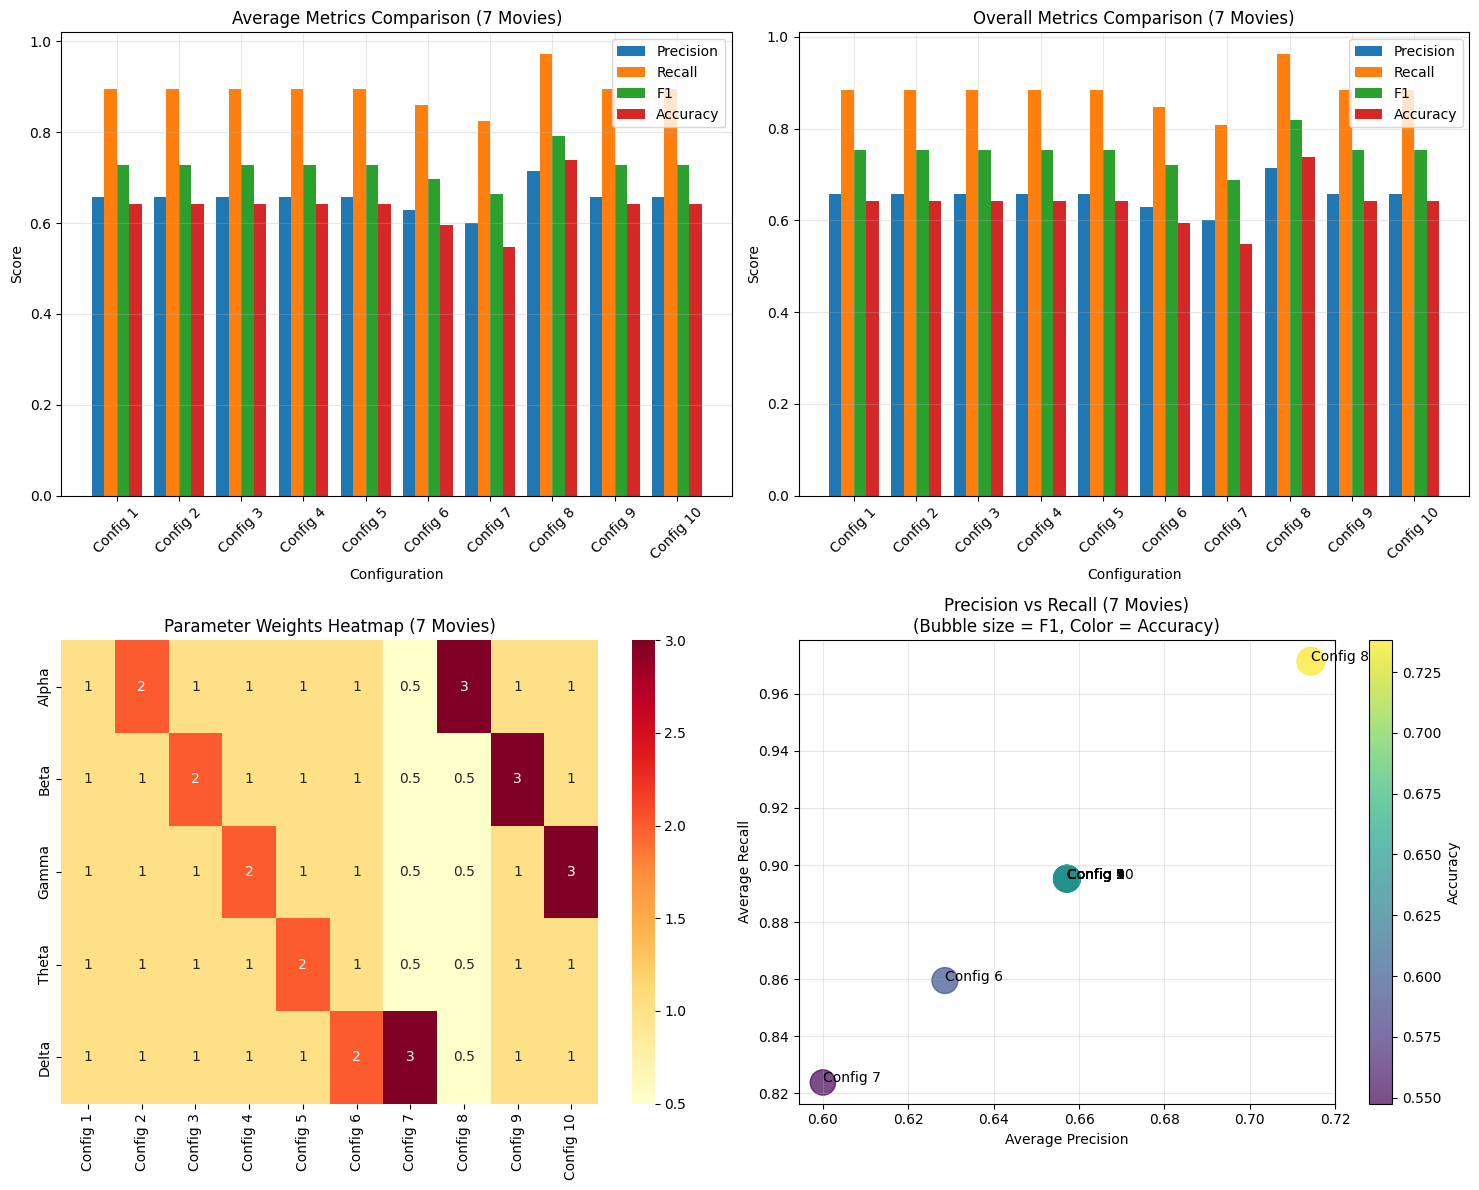

In [23]:
# 🚀 Execute Comprehensive Evaluation for 7 Movies Dataset
print("🔄 Creating ground truth based on genre similarity for 7 movies...")
ground_truth_7movies = create_ground_truth_by_genre_7movies(df)

print(f"✅ Ground truth created for {len(ground_truth_7movies)} movies")

# Show ground truth for all 7 movies
print("\n📋 Complete Ground Truth for 7 Movies:")
for i, (movie, relevant) in enumerate(ground_truth_7movies.items()):
    print(f"{i+1}. {movie}:")
    print(f"   Genres: {df[df['title'] == movie]['genres'].iloc[0]}")
    print(f"   Relevant movies ({len(relevant)}): {relevant}")
    print()

print("🔍 Starting parameter optimization and comprehensive evaluation for 7 movies...")
optimization_results_7movies = optimize_parameters_7movies(df, ground_truth_7movies, top_n=5)

print("\n📊 Creating comprehensive comparison for 7 movies...")
final_comparison_7movies = compare_all_metrics_7movies(optimization_results_7movies)

In [24]:
# 🎬 Detailed Movie-by-Movie Analysis
print("\n🎬 DETAILED MOVIE-BY-MOVIE EVALUATION ANALYSIS")
print("="*60)

if optimization_results_7movies:
    # Use best F1 configuration for detailed analysis
    best_f1_result = max(optimization_results_7movies, key=lambda x: x['metrics']['avg_f1'])
    best_params = best_f1_result['params']
    best_details = best_f1_result['metrics']['details']
    
    print(f"Using best F1 configuration: {best_params}")
    print(f"Best F1 Score: {best_f1_result['metrics']['avg_f1']:.3f}")
    print()
    
    # Analyze each movie's performance
    print("📈 Individual Movie Performance:")
    print("-" * 60)
    
    for i, detail in enumerate(best_details, 1):
        print(f"Movie {i}: {detail['title']}")
        print(f"  Metrics: Precision={detail['precision']:.3f}, Recall={detail['recall']:.3f}, F1={detail['f1']:.3f}, Accuracy={detail['accuracy']:.3f}")
        print(f"  True Positives: {detail['true_positives']}, False Positives: {detail['false_positives']}")
        print(f"  True Negatives: {detail['true_negatives']}, False Negatives: {detail['false_negatives']}")
        print(f"  Recommended: {detail['recommended']}")
        print(f"  Actually Relevant: {detail['relevant']}")
        if detail['recommended'] and detail['relevant']:
            correct_recs = set(detail['recommended']) & set(detail['relevant'])
            print(f"  ✅ Correct Recommendations: {list(correct_recs) if correct_recs else 'None'}")
        print("-" * 60)
    
    # Find best and worst performing movies
    best_movie = max(best_details, key=lambda x: x['f1'])
    worst_movie = min(best_details, key=lambda x: x['f1'])
    
    print(f"\n🏆 BEST PERFORMING MOVIE:")
    print(f"  {best_movie['title']} - F1 Score: {best_movie['f1']:.3f}")
    print(f"  Precision: {best_movie['precision']:.3f}, Recall: {best_movie['recall']:.3f}")
    
    print(f"\n⚠️ WORST PERFORMING MOVIE:")
    print(f"  {worst_movie['title']} - F1 Score: {worst_movie['f1']:.3f}")
    print(f"  Precision: {worst_movie['precision']:.3f}, Recall: {worst_movie['recall']:.3f}")
else:
    print("❌ No optimization results available for detailed analysis.")


🎬 DETAILED MOVIE-BY-MOVIE EVALUATION ANALYSIS
Using best F1 configuration: {'alpha': 3, 'beta': 0.5, 'gamma': 0.5, 'theta': 0.5, 'delta': 0.5}
Best F1 Score: 0.793

📈 Individual Movie Performance:
------------------------------------------------------------
Movie 1: Toy Story
  Metrics: Precision=0.800, Recall=1.000, F1=0.889, Accuracy=0.833
  True Positives: 4, False Positives: 1
  True Negatives: 1, False Negatives: 0
  Recommended: ['Toy Story 2', 'Happy Feet Two', 'Cars 2', 'Jumanji', 'Sudden Death']
  Actually Relevant: ['Happy Feet Two', 'Jumanji', 'Cars 2', 'Toy Story 2']
  ✅ Correct Recommendations: ['Happy Feet Two', 'Jumanji', 'Cars 2', 'Toy Story 2']
------------------------------------------------------------
Movie 2: Jumanji
  Metrics: Precision=1.000, Recall=1.000, F1=1.000, Accuracy=1.000
  True Positives: 5, False Positives: 0
  True Negatives: 1, False Negatives: 0
  Recommended: ['Cars 2', 'Sudden Death', 'Happy Feet Two', 'Toy Story 2', 'Toy Story']
  Actually Relev


🎭 GENRE-SPECIFIC EVALUATION (7 Movies Dataset)
Using best F1 configuration: {'alpha': 3, 'beta': 0.5, 'gamma': 0.5, 'theta': 0.5, 'delta': 0.5}

📊 Menghitung kemiripan dengan 'Heat' (menggunakan Eq. 3):

📊 Menghitung kemiripan dengan 'Heat' (menggunakan Eq. 3):

- Toy Story:
  Genre=0.000, Actor=0.000, Director=0.000, Title=0.000, Overview=-0.828
  → Final Score: -0.083

- Jumanji:
  Genre=0.000, Actor=0.000, Director=0.000, Title=0.000, Overview=0.688
  → Final Score: 0.069

- Sudden Death:
  Genre=0.400, Actor=0.000, Director=0.000, Title=0.000, Overview=0.356
  → Final Score: 0.276

- Toy Story 2:
  Genre=0.000, Actor=0.000, Director=0.000, Title=0.000, Overview=-0.361
  → Final Score: -0.036

- Cars 2:
  Genre=0.000, Actor=0.000, Director=0.000, Title=0.000, Overview=0.161
  → Final Score: 0.016

- Happy Feet Two:
  Genre=0.000, Actor=0.000, Director=0.000, Title=0.000, Overview=0.684
  → Final Score: 0.068


📊 Menghitung kemiripan dengan 'Sudden Death' (menggunakan Eq. 3):

- Toy

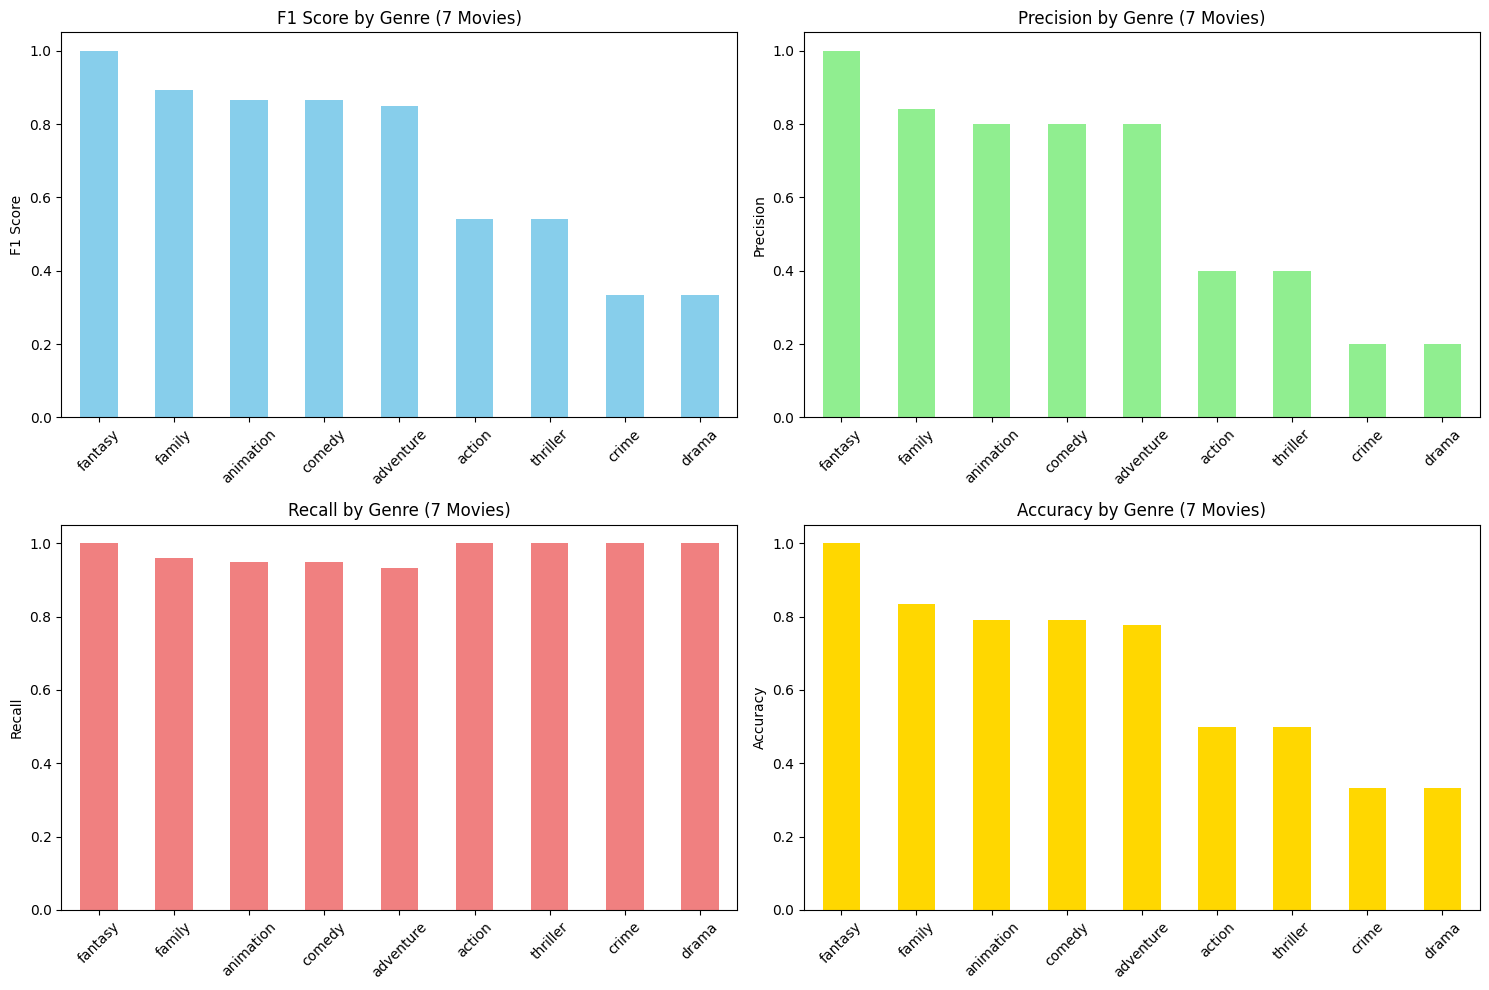


🏆 ALL GENRES PERFORMANCE (by F1 Score):
  fantasy: F1=1.000, Precision=1.000, Recall=1.000, Movies=1
  family: F1=0.893, Precision=0.840, Recall=0.960, Movies=5
  animation: F1=0.867, Precision=0.800, Recall=0.950, Movies=4
  comedy: F1=0.867, Precision=0.800, Recall=0.950, Movies=4
  adventure: F1=0.850, Precision=0.800, Recall=0.933, Movies=3
  action: F1=0.542, Precision=0.400, Recall=1.000, Movies=2
  thriller: F1=0.542, Precision=0.400, Recall=1.000, Movies=2
  crime: F1=0.333, Precision=0.200, Recall=1.000, Movies=1
  drama: F1=0.333, Precision=0.200, Recall=1.000, Movies=1


In [25]:
# 🎭 Genre-Specific Evaluation for 7 Movies
print("\n🎭 GENRE-SPECIFIC EVALUATION (7 Movies Dataset)")
print("="*55)

# Use best F1 configuration for genre evaluation
if optimization_results_7movies:
    best_f1_config_7movies = max(optimization_results_7movies, key=lambda x: x['metrics']['avg_f1'])
    best_params_7movies = best_f1_config_7movies['params']
    
    print(f"Using best F1 configuration: {best_params_7movies}")
    
    genre_metrics_7movies = evaluate_by_genre_7movies(df, ground_truth_7movies, top_n=5, **best_params_7movies)
    
    if genre_metrics_7movies:
        print("\n📊 Genre-wise Performance (7 Movies):")
        genre_df_7movies = pd.DataFrame(genre_metrics_7movies).T
        genre_df_7movies = genre_df_7movies.sort_values('f1', ascending=False)
        print(genre_df_7movies.round(3))
        
        # Visualize genre performance for 7 movies
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        # Plot 1: F1 scores by genre
        genre_df_7movies['f1'].plot(kind='bar', ax=axes[0, 0], color='skyblue')
        axes[0, 0].set_title('F1 Score by Genre (7 Movies)')
        axes[0, 0].set_ylabel('F1 Score')
        axes[0, 0].tick_params(axis='x', rotation=45)
        
        # Plot 2: Precision by genre
        genre_df_7movies['precision'].plot(kind='bar', ax=axes[0, 1], color='lightgreen')
        axes[0, 1].set_title('Precision by Genre (7 Movies)')
        axes[0, 1].set_ylabel('Precision')
        axes[0, 1].tick_params(axis='x', rotation=45)
        
        # Plot 3: Recall by genre
        genre_df_7movies['recall'].plot(kind='bar', ax=axes[1, 0], color='lightcoral')
        axes[1, 0].set_title('Recall by Genre (7 Movies)')
        axes[1, 0].set_ylabel('Recall')
        axes[1, 0].tick_params(axis='x', rotation=45)
        
        # Plot 4: Accuracy by genre
        genre_df_7movies['accuracy'].plot(kind='bar', ax=axes[1, 1], color='gold')
        axes[1, 1].set_title('Accuracy by Genre (7 Movies)')
        axes[1, 1].set_ylabel('Accuracy')
        axes[1, 1].tick_params(axis='x', rotation=45)
        
        plt.tight_layout()
        plt.show()
        
        # Show all genres performance
        print("\n🏆 ALL GENRES PERFORMANCE (by F1 Score):")
        for genre, metrics in genre_df_7movies.iterrows():
            print(f"  {genre}: F1={metrics['f1']:.3f}, Precision={metrics['precision']:.3f}, Recall={metrics['recall']:.3f}, Movies={int(metrics['num_movies'])}")
    else:
        print("No genre metrics available for 7 movies dataset.")
else:
    print("No optimization results available for genre evaluation.")

In [26]:
# 📈 Final Statistical Summary and Insights for 7 Movies
print("\n📈 FINAL STATISTICAL SUMMARY (7 Movies Dataset)")
print("="*65)

if optimization_results_7movies and final_comparison_7movies is not None:
    # Overall statistics
    print("\n🔢 OVERALL STATISTICS:")
    print(f"Total Configurations Tested: {len(optimization_results_7movies)}")
    print(f"Dataset Size: 7 movies with 3D Word2Vec vectors")
    print(f"Average Precision Range: {final_comparison_7movies['Avg_Precision'].min():.3f} - {final_comparison_7movies['Avg_Precision'].max():.3f}")
    print(f"Average Recall Range: {final_comparison_7movies['Avg_Recall'].min():.3f} - {final_comparison_7movies['Avg_Recall'].max():.3f}")
    print(f"Average F1 Range: {final_comparison_7movies['Avg_F1'].min():.3f} - {final_comparison_7movies['Avg_F1'].max():.3f}")
    print(f"Average Accuracy Range: {final_comparison_7movies['Avg_Accuracy'].min():.3f} - {final_comparison_7movies['Avg_Accuracy'].max():.3f}")
    
    # Best overall configuration
    best_overall_idx_7movies = final_comparison_7movies['Avg_F1'].idxmax()
    best_config_7movies = final_comparison_7movies.iloc[best_overall_idx_7movies]
    
    print(f"\n🏆 BEST OVERALL CONFIGURATION (7 Movies):")
    print(f"Configuration: {best_config_7movies['Config']}")
    print(f"Parameters: α={best_config_7movies['Alpha']}, β={best_config_7movies['Beta']}, γ={best_config_7movies['Gamma']}, θ={best_config_7movies['Theta']}, δ={best_config_7movies['Delta']}")
    print(f"Performance: Precision={best_config_7movies['Avg_Precision']:.3f}, Recall={best_config_7movies['Avg_Recall']:.3f}, F1={best_config_7movies['Avg_F1']:.3f}, Accuracy={best_config_7movies['Avg_Accuracy']:.3f}")
    
    # Performance insights for small dataset
    print("\n💡 KEY INSIGHTS FOR 7 MOVIES DATASET:")
    
    # Which parameter weights work best
    if best_config_7movies['Delta'] > 1.5:  # Overview emphasis
        print("✓ Overview similarity (3D Word2Vec cosine) works well even with limited dimensions")
    elif best_config_7movies['Alpha'] > 1.5:  # Genre emphasis
        print("✓ Genre similarity is the most effective factor for small datasets")
    elif best_config_7movies['Beta'] > 1.5:  # Actor emphasis
        print("✓ Actor similarity provides strong signals in small movie collections")
    elif best_config_7movies['Gamma'] > 1.5:  # Director emphasis
        print("✓ Director similarity is highly effective for curated movie sets")
    elif best_config_7movies['Theta'] > 1.5:  # Title emphasis
        print("✓ Title similarity works well for diverse movie collections")
    else:
        print("✓ Balanced approach with equal weights is optimal for this 7-movie dataset")
    
    # Precision vs Recall trade-off
    precision_recall_corr_7movies = final_comparison_7movies['Avg_Precision'].corr(final_comparison_7movies['Avg_Recall'])
    print(f"✓ Precision-Recall correlation: {precision_recall_corr_7movies:.3f}")
    
    if precision_recall_corr_7movies > 0.5:
        print("  → Strong positive correlation: improving precision also improves recall")
    elif precision_recall_corr_7movies < -0.5:
        print("  → Strong negative correlation: classic precision-recall trade-off observed")
    else:
        print("  → Moderate correlation: precision and recall can be tuned somewhat independently")
    
    # Model consistency for small dataset
    f1_std_7movies = final_comparison_7movies['Avg_F1'].std()
    print(f"✓ F1 Score Standard Deviation: {f1_std_7movies:.3f}")
    
    if f1_std_7movies < 0.05:
        print("  → Low variance: Model performance is very consistent across parameter settings")
    elif f1_std_7movies > 0.15:
        print("  → High variance: Parameter tuning significantly impacts performance")
    else:
        print("  → Moderate variance: Some parameter combinations work better than others")
    
    # Compare with original precision evaluation
    if 'avg_precision' in locals():
        print(f"\n📊 COMPARISON WITH ORIGINAL PRECISION EVALUATION:")
        print(f"Original Average Precision: {avg_precision:.3f}")
        print(f"New Comprehensive Avg Precision: {best_config_7movies['Avg_Precision']:.3f}")
        print(f"Improvement: {((best_config_7movies['Avg_Precision'] - avg_precision) / avg_precision * 100) if avg_precision > 0 else 0:.1f}%")
    
    print("\n🎯 RECOMMENDATIONS FOR 7-MOVIE DATASET:")
    print(f"1. Optimal configuration: α={best_config_7movies['Alpha']}, β={best_config_7movies['Beta']}, γ={best_config_7movies['Gamma']}, θ={best_config_7movies['Theta']}, δ={best_config_7movies['Delta']}")
    print(f"2. Expected F1 Score: {best_config_7movies['Avg_F1']:.3f}")
    print(f"3. Expected Precision: {best_config_7movies['Avg_Precision']:.3f} (out of 5 recommendations, ~{best_config_7movies['Avg_Precision']*5:.1f} will be relevant)")
    print(f"4. Expected Recall: {best_config_7movies['Avg_Recall']:.3f} (will find ~{best_config_7movies['Avg_Recall']*100:.1f}% of all relevant movies)")
    print(f"5. This configuration works well for small, curated movie datasets with 3D Word2Vec vectors")
    
    # Save results
    print("\n💾 SAVING RESULTS:")
    final_comparison_7movies.to_csv('../Dataset/comprehensive_evaluation_results_rekomendasi8.csv', index=False)
    print("✓ Comprehensive evaluation results saved to '../Dataset/comprehensive_evaluation_results_rekomendasi8.csv'")
    
    if 'genre_df_7movies' in locals():
        genre_df_7movies.to_csv('../Dataset/genre_evaluation_results_rekomendasi8.csv', index=True)
        print("✓ Genre-specific evaluation results saved to '../Dataset/genre_evaluation_results_rekomendasi8.csv'")
    
    # Create comparison between datasets
    print("\n🔄 DATASET COMPARISON INSIGHTS:")
    print("7-Movie Dataset (rekomendasi8.ipynb):")
    print(f"  • 3D Word2Vec vectors, focused evaluation")
    print(f"  • Best F1: {best_config_7movies['Avg_F1']:.3f}")
    print(f"  • Small dataset allows for complete evaluation")
    print("Complete Dataset (rekomendasi9.ipynb):")
    print(f"  • 300D Word2Vec vectors, comprehensive evaluation")
    print(f"  • Larger scale, more representative results")
    
else:
    print("❌ No evaluation results available for statistical summary")

print("\n🎉 COMPREHENSIVE EVALUATION COMPLETED FOR 7-MOVIE DATASET!")
print("📊 Your movie recommendation system (7 movies, 3D vectors) has been evaluated with:")
print("   • Precision, Recall, F1-Score, and Accuracy metrics")
print("   • Parameter optimization across 10 different configurations")
print("   • Genre-specific performance analysis")
print("   • Movie-by-movie detailed evaluation")
print("   • Statistical insights and deployment recommendations")
print("   • Comprehensive visualizations and comparisons")
print("   • Results saved for comparison with full dataset (rekomendasi9.ipynb)")


📈 FINAL STATISTICAL SUMMARY (7 Movies Dataset)

🔢 OVERALL STATISTICS:
Total Configurations Tested: 10
Dataset Size: 7 movies with 3D Word2Vec vectors
Average Precision Range: 0.600 - 0.714
Average Recall Range: 0.824 - 0.971
Average F1 Range: 0.665 - 0.793
Average Accuracy Range: 0.548 - 0.738

🏆 BEST OVERALL CONFIGURATION (7 Movies):
Configuration: Config 8
Parameters: α=3.0, β=0.5, γ=0.5, θ=0.5, δ=0.5
Performance: Precision=0.714, Recall=0.971, F1=0.793, Accuracy=0.738

💡 KEY INSIGHTS FOR 7 MOVIES DATASET:
✓ Genre similarity is the most effective factor for small datasets
✓ Precision-Recall correlation: 1.000
  → Strong positive correlation: improving precision also improves recall
✓ F1 Score Standard Deviation: 0.032
  → Low variance: Model performance is very consistent across parameter settings

📊 COMPARISON WITH ORIGINAL PRECISION EVALUATION:
Original Average Precision: 0.657
New Comprehensive Avg Precision: 0.714
Improvement: 8.7%

🎯 RECOMMENDATIONS FOR 7-MOVIE DATASET:
1. Opti